In [1]:
import numpy as np
import pandas as pd
from skimage import io, feature, color, filters
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from radiomics import glrlm, glszm, ngtdm, gldm, firstorder
import matplotlib.pyplot as plt
import SimpleITK as sitk
import six
import cv2
import os

# Function to convert a numpy array to a SimpleITK Image
def numpy_to_sitk(array):
    sitk_image = sitk.GetImageFromArray(array)
    return sitk_image

# Example function to compute first-order statistical features
def compute_first_order_features(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = color.rgb2gray(image)

    # Quantize image to 256 levels (8 bits)
    image_quantized = (image * 255).astype('uint8')

    # Convert numpy array to SimpleITK Image
    sitk_image = numpy_to_sitk(image_quantized)

    # Create a mask that covers the entire image
    mask = np.ones(image_quantized.shape, dtype=np.uint8)

    # Convert mask to SimpleITK Image
    sitk_mask = numpy_to_sitk(mask)

    firstOrderFeatures = firstorder.RadiomicsFirstOrder(sitk_image, sitk_mask)

    firstOrderFeatures.enableAllFeatures()
    results = firstOrderFeatures.execute()

    first_order_features = results

    # for g in first_order_features:
    #     print(g)

    return list(first_order_features.values())

# Compute GLCM features
def compute_glcm_features(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    
    # Quantize image to 256 levels (8 bits)
    image_quantized = (image * 255).astype('uint8')

    # Compute GLCM matrix
    glcm = graycomatrix(image_quantized, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)

    # Compute features from GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    asm = graycoprops(glcm, 'ASM')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    # Return the mean and maximum values of these features
    return np.mean(contrast), np.max(contrast), np.mean(dissimilarity), np.max(dissimilarity), \
           np.mean(homogeneity), np.max(homogeneity), np.mean(asm), np.max(asm), \
           np.mean(energy), np.max(energy), np.mean(correlation), np.max(correlation)

# Function to compute GLRLM features
def compute_glrlm_features(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = color.rgb2gray(image)

    # Quantize image to 256 levels (8 bits)
    image_quantized = (image * 255).astype('uint8')

    # Convert numpy array to SimpleITK Image
    sitk_image = numpy_to_sitk(image_quantized)

    # Create a mask that covers the entire image
    mask = np.ones(image_quantized.shape, dtype=np.uint8)

    # Convert mask to SimpleITK Image
    sitk_mask = numpy_to_sitk(mask)

    glrlmFeatures = glrlm.RadiomicsGLRLM(sitk_image, sitk_mask)
    glrlmFeatures.enableAllFeatures()

    # print('Will calculate the following GLRLM features: ')
    for f in glrlmFeatures.enabledFeatures.keys():
    #     print('  ', f)
    #     print(getattr(glrlmFeatures, 'get%sFeatureValue' % f).__doc__)

    #     print('Calculating GLRLM features...')
        results = glrlmFeatures.execute()
    #     print('done')

    #     print('Calculated GLRLM features: ')
    #     for (key, val) in six.iteritems(results):
    #         print('  ', key, ':', val)

        glrlm_features = results

    # for g in glrlm_features:
    #     print(g)
    # Extract specific features
    sre = glrlm_features['ShortRunEmphasis']
    lre = glrlm_features['LongRunEmphasis']
    gln = glrlm_features['GrayLevelNonUniformity']
    rln = glrlm_features['RunLengthNonUniformity']
    rp = glrlm_features['RunPercentage']
    lgre = glrlm_features['LowGrayLevelRunEmphasis']
    hgre = glrlm_features['HighGrayLevelRunEmphasis']
    srlge = glrlm_features['ShortRunLowGrayLevelEmphasis']
    srhge = glrlm_features['ShortRunHighGrayLevelEmphasis']
    lrlge = glrlm_features['LongRunLowGrayLevelEmphasis']
    lrhge = glrlm_features['LongRunHighGrayLevelEmphasis']
    glnn = glrlm_features['GrayLevelNonUniformityNormalized']
    glv = glrlm_features['GrayLevelVariance']
    re = glrlm_features['RunEntropy']
    rlnn = glrlm_features['RunLengthNonUniformityNormalized']
    rv = glrlm_features['RunVariance']

    return [sre, lre, gln, rln, rp, lgre, hgre, srlge, srhge, lrlge, lrhge, glnn, glv, re, rlnn, rv]

# Function to compute GLSZM features
def compute_glszm_features(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        image = color.rgb2gray(image)

    # Quantize image to 256 levels (8 bits)
    image_quantized = (image * 255).astype('uint8')

    # Convert numpy array to SimpleITK Image
    sitk_image = numpy_to_sitk(image_quantized)

    # Create a mask that covers the entire image
    mask = np.ones(image_quantized.shape, dtype=np.uint8)

    # Convert mask to SimpleITK Image
    sitk_mask = numpy_to_sitk(mask)

    glszmFeatures = glszm.RadiomicsGLSZM(sitk_image, sitk_mask)
    glszmFeatures.enableAllFeatures()

    for f in glszmFeatures.enabledFeatures.keys():
        results = glszmFeatures.execute()
        glszm_features = results

    # for g in glszm_features:
    #     print(g)
    # Extract specific features
    sae = glszm_features['SmallAreaEmphasis']
    lae = glszm_features['LargeAreaEmphasis']
    gln = glszm_features['GrayLevelNonUniformity']
    szn = glszm_features['SizeZoneNonUniformity']
    zp = glszm_features['ZonePercentage']
    lgze = glszm_features['LowGrayLevelZoneEmphasis']
    salge = glszm_features['SmallAreaLowGrayLevelEmphasis']
    sahge = glszm_features['SmallAreaHighGrayLevelEmphasis']
    lalge = glszm_features['LargeAreaLowGrayLevelEmphasis']
    lahge = glszm_features['LargeAreaHighGrayLevelEmphasis']
    glnn = glszm_features['GrayLevelNonUniformityNormalized']
    glv = glszm_features['GrayLevelVariance']
    hglze = glszm_features['HighGrayLevelZoneEmphasis']
    ze = glszm_features['ZoneEntropy']
    sznn = glszm_features['SizeZoneNonUniformityNormalized']
    zv = glszm_features['ZoneVariance']

    return [gln, glnn, glv, hglze, lae, lahge, lalge, lgze, szn, sznn, sae, sahge, salge, ze, zp, zv]

# Function to compute NGTDM features
def compute_ngtdm_features(image):

    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    image_quantized = (image * 255).astype('uint8')
    sitk_image = numpy_to_sitk(image_quantized)
    mask = np.ones(image_quantized.shape, dtype=np.uint8)
    sitk_mask = numpy_to_sitk(mask)

    ngtdmFeatures = ngtdm.RadiomicsNGTDM(sitk_image, sitk_mask)
    ngtdmFeatures.enableAllFeatures()
    results = ngtdmFeatures.execute()

    ngtdm_features = results

    # for g in ngtdm_features:
    #     print(g)

    return list(ngtdm_features.values())

# Function to compute GLDM features
def compute_gldm_features(image):
    
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    image_quantized = (image * 255).astype('uint8')
    sitk_image = numpy_to_sitk(image_quantized)
    mask = np.ones(image_quantized.shape, dtype=np.uint8)
    sitk_mask = numpy_to_sitk(mask)

    gldmFeatures = gldm.RadiomicsGLDM(sitk_image, sitk_mask)
    gldmFeatures.enableAllFeatures()
    results = gldmFeatures.execute()

    gldm_features = results

    # for g in gldm_features:
    #     print(g)

    return list(gldm_features.values())

# Function to compute gabor features
def compute_gabor_features(image):
    # Convert the image to grayscale (if it's not already)
    if len(image.shape) > 2:
        image = color.rgb2gray(image)

    # Define Gabor filter parameters
    frequency = 0.6  # Frequency of the sinusoidal function
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]       # Orientation of the Gabor filter

    # Apply Gabor filter
    gabor_responses = []
    for theta in thetas:
        response, _ = filters.gabor(image, frequency=frequency, theta=theta)
        gabor_responses.append(response)

    # Calculate feature(s) from the Gabor response, e.g., mean response
    mean = np.mean(gabor_responses)
    maximum = np.max(gabor_responses)
    std_dev = np.std(gabor_responses)
    return [mean, maximum, std_dev]

def process_image(image_path):
    image = io.imread(image_path)
    first_order_features = compute_first_order_features(image)
    glcm_features = compute_glcm_features(image)
    glrlm_features = compute_glrlm_features(image)
    glszm_features = compute_glszm_features(image)
    ngtdm_features = compute_ngtdm_features(image)
    gldm_features = compute_gldm_features(image)
    gabor_features = compute_gabor_features(image)
    all_features = first_order_features + list(glcm_features) + glrlm_features + glszm_features + ngtdm_features + gldm_features + gabor_features
    return all_features

# Load an example image (placeholder, replace with actual mammogram image)
all_images_features = []

train_path = os.path.join("/Volumes/Extreme/roi_data/manifest-LyDgOQGl3853937313152078328")
train_image_path = []
train_label = []
for i,filename in enumerate(os.listdir(train_path+"/benign")):
    train_image_path.append((train_path+"/benign/"+filename,"benign"))
for i,filename in enumerate(os.listdir(train_path+"/malignant")):
    train_image_path.append((train_path+"/malignant/"+filename,"malignant"))
for path,l in train_image_path:
    if path.split("/")[6][0] == '.':
        continue
    image_features = []
    if l == 'benign':
        image_features.append(0)
    else:
        image_features.append(1)
    image_features += process_image(path)
    # print(image_features)
    all_images_features.append(image_features)

# Convert to DataFrame
feature_columns = ['type','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation',
                   'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 
                   'Uniformity', 'Variance',
                   'GLCM Mean Contrast', 'GLCM Max Contrast', 'GLCM Mean Dissimilarity', 'GLCM Max Dissimilarity',
                   'GLCM Mean Homogeneity', 'GLCM Max Homogeneity', 'GLCM Mean ASM', 'GLCM Max ASM',
                   'GLCM Mean Energy', 'GLCM Max Energy', 'GLCM Mean Correlation', 'GLCM Max Correlation', 'GLRLM SRE', 'GLRLM LRE', 'GLRLM GLN',
                   'GLRLM RLN', 'GLRLM RP', 'GLRLM LGRE', 'GLRLM HGRE', 'GLRLM SRLGE', 'GLRLM SRHGE', 'GLRLM LRLGE', 'GLRLM LRHGE', 'GLRLM GLNN', 
                   'GLRLM GLV', 'GLRLM RE', 'GLRLM RLNN', 'GLRLM RV',
                   'GLSZM GLN', 'GLSZM GLNN', 'GLSZM GLV', 'GLSZM HGLZE', 'GLSZM LAE', 'GLSZM LAHGLE', 'GLSZM LALGLE', 'GLSZM LGLZE', 'GLSZM SZNU',
                   'GLSZM SZNUN', 'GLSZM SAE', 'GLSZM SAHGLE', 'GLSZM SALGLE', 'GLSZM ZE', 'GLSZM ZP', 'GLSZM ZV',
                   'NGTDM Busyness', 'NGTDM Coarseness', 'NGTDM Complexity', 'NGTDM Contrast', 'NGTDM Strength',
                   'GLDM DE', 'GLDM DNU', 'GLDM DNUN', 'GLDM DV', 'GLDM GLNU', 'GLDM GLV', 'GLDM HGLE', 'GLDM LDE', 'GLDM LDHGLE', 'GLDM LDLGLE',
                   'GLDM LGLE', 'GLDM SDE', 'GLDM SDHGLE', 'GLDM SDLGLE',
                   'Gabor Mean', 'Gabor Max', 'Gabor Std Dev']
feature_df = pd.DataFrame(all_images_features, columns=feature_columns)

feature_df

,type,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,...,GLDM LDE,GLDM LDHGLE,GLDM LDLGLE,GLDM LGLE,GLDM SDE,GLDM SDHGLE,GLDM SDLGLE,Gabor Mean,Gabor Max,Gabor Std Dev
0,0,25.0,230.0,4822670053.0,3.4012292915865405,128.0,1.7963743569166137,255.0,64.10067894768109,127.48295902507152,...,3.8629738922803143,153.3540287883225,0.6002098032000307,0.15266853070775663,0.5567493120991629,22.947838979435023,0.08357507071286742,6311.225639,65535,16719.493608
1,0,25.0,230.0,1155843293.0,3.4032413993826647,128.0,1.7984998631320597,255.0,63.99698765936064,127.84364630467572,...,3.8376696832579187,152.18016591251885,0.5735905142539827,0.15025259979203098,0.5597604086506398,23.3124726615005,0.08372523400125093,2313.579091,65535,5348.174909
2,0,26.0,230.0,1301117413.0,3.4044896054068516,128.0,1.8056776407514425,255.0,63.78906564115502,128.01611875209662,...,3.835692720563569,151.78118081180813,0.574353105239011,0.14987567977465308,0.5602024395243952,23.224794536695367,0.08428186343276918,4208.764739,65535,12394.419597
3,0,25.0,230.0,2293396614.0,3.407063877818568,128.0,1.7930865475985867,255.0,64.14472189998435,127.72113923088615,...,3.96156330749354,158.20566385468916,0.5917693042286257,0.15022344482171793,0.5518659166939817,22.846390994543814,0.08272449376500268,6187.357268,65535,16166.682672
4,0,25.0,229.0,1691915396.0,3.4053516881998025,127.0,1.8019904388674324,255.0,63.940954572505454,127.33887323943662,...,3.8240717029449423,148.97824583866839,0.5828072880667232,0.15117607120129323,0.5614308628829252,23.40254700671562,0.08437817682795769,6285.507743,65535,16643.252168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,1,25.0,230.0,9820228748.0,3.4018697980931685,129.0,1.8018887697383965,255.0,63.97242819449572,127.24346633625385,...,3.883031214311226,152.54777169767226,0.5959704927273216,0.15196688755996313,0.5563678951946349,22.92064849591104,0.08375533881858015,3211.891365,65535,9433.559710
1235,1,25.0,230.0,3604096021.0,3.4053051005713937,128.0,1.800101303697947,255.0,64.01749945318183,127.99990908154173,...,3.8242424977118854,151.57971427359183,0.5628269450635763,0.14808822826689436,0.5596098064965204,23.22554728166661,0.08341477482400102,2890.586763,65535,8058.445400
1236,1,25.0,229.0,4028209733.0,3.4061087829625722,128.0,1.801077273150639,255.0,63.94335521616006,127.52870352896772,...,3.8069015717251236,150.63592591594102,0.5690960748531042,0.14982463693571133,0.5626036722797568,23.36735021233936,0.08406497770264243,6507.057236,65535,17462.111985
1237,1,26.0,230.0,931986351.0,3.4016051828339338,129.0,1.7999728992452593,255.0,63.89279872968141,128.27075108103026,...,3.9172776837751457,155.62967663094565,0.5732794290602305,0.14756663145511703,0.5545413320354149,22.992190191118436,0.08185929019883385,1725.147414,65535,2050.191257


In [2]:
# Load an example image (placeholder, replace with actual mammogram image)
all_images_features_test = []

test_path = os.path.join("/Volumes/Extreme/roi_data/manifest-OlX3eVq41551709337535597984")
test_image_path = []
test_label = []
for i,filename in enumerate(os.listdir(test_path+"/benign")):
    test_image_path.append((test_path+"/benign/"+filename,"benign"))
for i,filename in enumerate(os.listdir(test_path+"/malignant")):
    test_image_path.append((test_path+"/malignant/"+filename,"malignant"))
for path,l in test_image_path:
    if path.split("/")[6][0] == '.':
        continue
    image_features = []
    if l == 'benign':
        image_features.append(0)
    else:
        image_features.append(1)
    image_features += process_image(path)
    # print(image_features)
    all_images_features_test.append(image_features)

# Convert to DataFrame
feature_columns = ['type','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation',
                   'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 
                   'Uniformity', 'Variance',
                   'GLCM Mean Contrast', 'GLCM Max Contrast', 'GLCM Mean Dissimilarity', 'GLCM Max Dissimilarity',
                   'GLCM Mean Homogeneity', 'GLCM Max Homogeneity', 'GLCM Mean ASM', 'GLCM Max ASM',
                   'GLCM Mean Energy', 'GLCM Max Energy', 'GLCM Mean Correlation', 'GLCM Max Correlation', 'GLRLM SRE', 'GLRLM LRE', 'GLRLM GLN',
                   'GLRLM RLN', 'GLRLM RP', 'GLRLM LGRE', 'GLRLM HGRE', 'GLRLM SRLGE', 'GLRLM SRHGE', 'GLRLM LRLGE', 'GLRLM LRHGE', 'GLRLM GLNN', 
                   'GLRLM GLV', 'GLRLM RE', 'GLRLM RLNN', 'GLRLM RV',
                   'GLSZM GLN', 'GLSZM GLNN', 'GLSZM GLV', 'GLSZM HGLZE', 'GLSZM LAE', 'GLSZM LAHGLE', 'GLSZM LALGLE', 'GLSZM LGLZE', 'GLSZM SZNU',
                   'GLSZM SZNUN', 'GLSZM SAE', 'GLSZM SAHGLE', 'GLSZM SALGLE', 'GLSZM ZE', 'GLSZM ZP', 'GLSZM ZV',
                   'NGTDM Busyness', 'NGTDM Coarseness', 'NGTDM Complexity', 'NGTDM Contrast', 'NGTDM Strength',
                   'GLDM DE', 'GLDM DNU', 'GLDM DNUN', 'GLDM DV', 'GLDM GLNU', 'GLDM GLV', 'GLDM HGLE', 'GLDM LDE', 'GLDM LDHGLE', 'GLDM LDLGLE',
                   'GLDM LGLE', 'GLDM SDE', 'GLDM SDHGLE', 'GLDM SDLGLE',
                   'Gabor Mean', 'Gabor Max', 'Gabor Std Dev']
feature_df_test = pd.DataFrame(all_images_features_test, columns=feature_columns)

feature_df_test

,type,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,...,GLDM LDE,GLDM LDHGLE,GLDM LDLGLE,GLDM LGLE,GLDM SDE,GLDM SDHGLE,GLDM SDLGLE,Gabor Mean,Gabor Max,Gabor Std Dev
0,0,26.0,230.0,3337458646.0,3.4006635294850547,128.0,1.806027511894799,255.0,63.975170132659706,128.28350407144734,...,3.9162989230365115,156.96817047544,0.5703460436969366,0.14719234809933116,0.5527680706399538,22.899262952219242,0.08182648329972196,1886.427075,65534,1781.467855
1,0,25.0,230.0,4129441202.0,3.4036958094286875,130.0,1.785092551982729,255.0,64.40865671635024,127.8325062166023,...,3.948838685783821,158.2466641976615,0.6100050495468035,0.15353347268072734,0.5475717765475941,22.220748783223147,0.08350240460517512,1812.714765,65535,1746.802131
2,0,25.0,230.0,1772087553.0,3.408741896898334,130.0,1.791553046559893,255.0,64.3949580467686,128.2873482032218,...,4.037149938042131,160.1892936802974,0.5924581277470534,0.14926840866150565,0.5478301278917185,22.867714846425972,0.08182956288762218,6418.306769,65535,17256.972106
3,0,25.0,229.0,2343258956.0,3.404616437441134,127.0,1.798696077070851,255.0,63.98165448333552,126.77441287809181,...,4.0470800102907125,158.50861847182918,0.631424118818231,0.15386625228263598,0.5443040767682537,22.28424467583182,0.08249804743241516,7232.185878,65535,17918.063875
4,0,25.0,231.0,1034457484.0,3.385005822754335,129.0,1.7774625333526322,255.0,64.38762159432822,126.7518032103398,...,3.9373775276214302,156.63806545757765,0.6047098363757618,0.15402671237329887,0.5507384183330758,22.383373815456277,0.08378851464871115,3551.700870,65535,10795.820583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1,24.0,230.0,1045737574.0,3.4017722701896433,129.0,1.7891236770944412,255.0,64.19381653048788,127.38453235916809,...,3.8133587944705054,148.81724023413176,0.6097106740743404,0.15357509623344046,0.5608238342384707,23.20727976064573,0.08351310552141525,1754.556431,65535,3450.607585
363,1,27.0,236.0,2385149920.0,3.3974397183357685,135.0,1.7828920642610073,255.0,63.47373342535692,131.56924248191854,...,5.353254663113818,224.32993909402362,0.7215228682325278,0.13399668482584728,0.43638078001470854,18.469999524172056,0.05825949431191164,1819.483567,65535,1942.585758
364,1,10.0,227.0,1106764995.0,3.3668549080357053,136.0,1.7629645987287204,255.0,67.46092323147859,119.83652004126142,...,7.151083112290009,149.0336722664309,4.042141891718713,0.2014662183242168,0.5234382380003475,21.364327287554985,0.07846082908031544,10739.125180,65535,23430.647667
365,1,26.0,231.0,3028905475.0,3.4083225215343553,128.0,1.7992718297611907,255.0,64.04907901253763,128.15505427947787,...,3.8738490004192023,153.82429639052313,0.5906583040593402,0.15094150833562978,0.5564437605077156,23.184117550803744,0.08291145129106278,1783.532177,65528,1670.377158


In [5]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score

labels = feature_df['type']
features = feature_df.drop('type', axis=1)
# print('features: ', features)

# Feature Scaling (Z-score Standardization)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Feature Selection: ANOVA F-test
selector = SelectKBest(f_classif, k='all')
selected_features = selector.fit_transform(scaled_features, labels) 
# print('selected feature: ', selected_features)

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Perform PCA
# pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
# principal_components = pca.fit_transform(selected_features)

# # Create a DataFrame with the principal components and labels
# principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# principal_df['Label'] = labels.reset_index(drop=True)  # Reset index if labels is a Series
# # Plotting the 2D data
# plt.figure(figsize=(8, 6))
# for label in np.unique(labels):
#     indices = principal_df['Label'] == label
#     plt.scatter(principal_df.loc[indices, 'PC1'], principal_df.loc[indices, 'PC2'], label=label)

# plt.title('2D PCA of Selected Features')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()

# Feature Selection: Pearson Redundancy-Based Filter (PRBF)
def remove_highly_correlated(features, threshold=0.8):
    corr_matrix = features.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return features.drop(to_drop, axis=1)

selected_features_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = features.columns[selected_features_mask]  # Assuming 'features' is a DataFrame
selected_features_df = pd.DataFrame(selected_features, columns=selected_feature_names)
pruned_features = remove_highly_correlated(selected_features_df)
print('pruned feature: ', pruned_features.columns.tolist())

# # Ensure all data is numeric and fill or drop missing values
# pruned_features = pruned_features.apply(pd.to_numeric, errors='coerce')
# pruned_features = pruned_features.dropna(axis=1)

# Convert pruned_features and labels to numpy arrays
# X = pruned_features.values.astype(float)
# y = labels.values.astype(float)

# Feature Selection: Ordinary Least Squares (OLS) Backward Elimination
def backward_elimination(features, target, significance_level=0.1):
    features_with_const = sm.add_constant(features)
    # print('Features including const:', features_with_const.columns.tolist())

    for i in range(len(features.columns)):
        regressor_OLS = sm.OLS(target, features_with_const).fit()
        max_p_value = max(regressor_OLS.pvalues)
        if max_p_value > significance_level:
            excluded_feature = regressor_OLS.pvalues.idxmax()
            features_with_const = features_with_const.drop(columns=excluded_feature)
        else:
            break

    # Remove the 'const' column before returning
    features_without_const = features_with_const.drop(columns='const')
    return features_without_const

features_after_ols = backward_elimination(pruned_features, labels)
print('after ols feature: ', features_after_ols.columns.tolist())

# Feature Importance Ranking with XGBoost-embedded RFE
xgb = XGBClassifier()
select_num = 10 if len(features_after_ols) >= 10 else len(features_after_ols)
rfe = RFE(estimator=xgb, n_features_to_select=select_num)  # Adjust the number of features
rfe.fit(features_after_ols, labels)

top_features = features_after_ols.columns[rfe.support_]

print('top feature: ', top_features)

X_top_features = pruned_features[top_features]
# print(selected_features.shape, len(labels))

# Train-Test Split
y_train = feature_df['type']
X_train = feature_df.drop('type', axis=1)
y_test = feature_df_test['type']
X_test = feature_df_test.drop('type', axis=1)
print('y_train bad: ', np.sum(y_train == 1))
print('y_train good: ', np.sum(y_train == 0))
print('y_test bad: ', np.sum(y_test == 1))
print('y_test good: ', np.sum(y_test == 0))
# Train SVM Model
# Define parameter range for grid search
param_grid = {
    'C': [1, 0.1, 0.05, 0.01, 0.001],  # Example range, adjust as needed
    'gamma': [1, 0.1, 0.05, 0.01, 0.001],  # 'scale' and 'auto' are often used with non-linear kernels
    'kernel': ['rbf'],
}

# Create a GridSearchCV object
# grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Print out the best parameters
print("Best Parameters found by grid search:", grid_search.best_params_)

# Use the best estimator to make predictions
# Use the best estimator to make predictions
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)

# Calculate and print accuracy and F1 score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"SVM Best Model Accuracy: {accuracy_svm}")
print(f"SVM Best Model F1 Score: {f1_svm}")

from collections import Counter
print("Prediction distribution:", Counter(y_pred_svm))

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
f1 = f1_score(y_test, y_pred)
print(f"Logistic Regression F1 Score: {f1}")

# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict and Evaluate
y_pred_gnb = gnb.predict(X_test)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_gnb}")
f1_gnb = f1_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes F1 Score: {f1_gnb}")

# Train K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict and Evaluate
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
f1_knn = f1_score(y_test, y_pred_knn)
print(f"KNN F1 Score: {f1_knn}")

pruned feature:  ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'Maximum', 'Minimum', 'GLRLM SRE', 'GLRLM LGRE', 'GLRLM HGRE', 'GLRLM GLNN', 'GLRLM GLV', 'GLRLM RE', 'GLSZM SALGLE', 'NGTDM Coarseness', 'NGTDM Complexity', 'NGTDM Contrast', 'GLDM DE', 'Gabor Mean', 'Gabor Max']
after ols feature:  ['InterquartileRange', 'Kurtosis', 'GLRLM GLNN', 'NGTDM Coarseness']
top feature:  Index(['InterquartileRange', 'Kurtosis', 'GLRLM GLNN', 'NGTDM Coarseness'], dtype='object')
y_train bad:  600
y_train good:  639
y_test bad:  142
y_test good:  225
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ....................

In [49]:
from skimage import io, color, filters
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path1 = '../../datasets/image/clean_png/Mass-Training1.png'
image = io.imread(image_path1)

# Convert the image to grayscale (if it's not already)
if len(image.shape) > 2:
    image = color.rgb2gray(image)

# Define Gabor filter parameters
frequency = 0.6  # Frequency of the sinusoidal function
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]       # Orientation of the Gabor filter

# Apply Gabor filter
gabor_responses = []
for theta in thetas:
    response, _ = filters.gabor(image, frequency=frequency, theta=theta)
    gabor_responses.append(response)

# Calculate feature(s) from the Gabor response, e.g., mean response
gabor_feature = np.mean(gabor_responses)

# gabor_feature is now a feature you can use
print("Gabor feature (mean response):", gabor_feature)


Gabor feature (mean response): 6311.225639177348


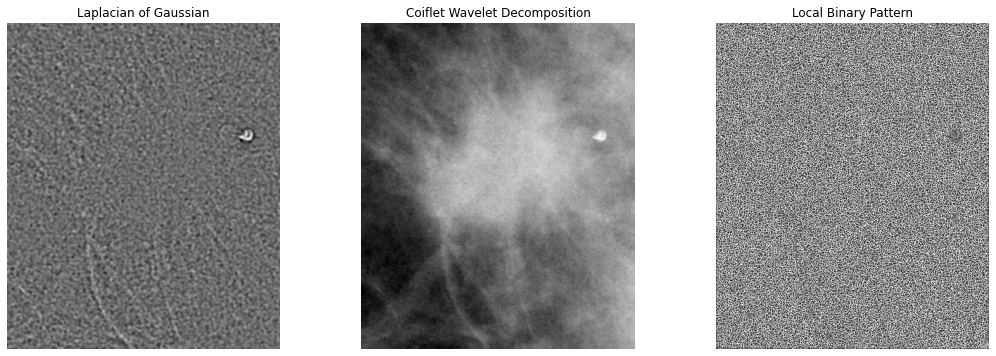

In [36]:
import numpy as np
from skimage import io, color, feature, filters
import pywt
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path1 = '../../datasets/image/clean_png/Mass-Training1.png'  # Replace with your image path
image = io.imread(image_path1)

# Convert the image to grayscale (if it's not already)
if len(image.shape) > 2:
    image = color.rgb2gray(image)

# Apply Laplacian of Gaussian (LoG)
log_image = filters.gaussian(image, sigma=2, mode='reflect')  # Adjust sigma as needed
log_image = filters.laplace(log_image)

# Apply Single Level Coiflet Wavelet Decomposition
coeffs = pywt.dwt2(image, 'coif1')
cA, (cH, cV, cD) = coeffs

# Apply Local Binary Pattern
radius = 1  # Radius of 3x3 window
n_points = 8 * radius
lbp_image = feature.local_binary_pattern(image, n_points, radius, method="uniform")

# Display the transformed images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax = axes.ravel()

ax[0].imshow(log_image, cmap=plt.cm.gray)
ax[0].set_title('Laplacian of Gaussian')
ax[0].axis('off')

ax[1].imshow(cA, cmap=plt.cm.gray)  # Approximation coefficients
ax[1].set_title('Coiflet Wavelet Decomposition')
ax[1].axis('off')

ax[2].imshow(lbp_image, cmap=plt.cm.gray)
ax[2].set_title('Local Binary Pattern')
ax[2].axis('off')

plt.show()

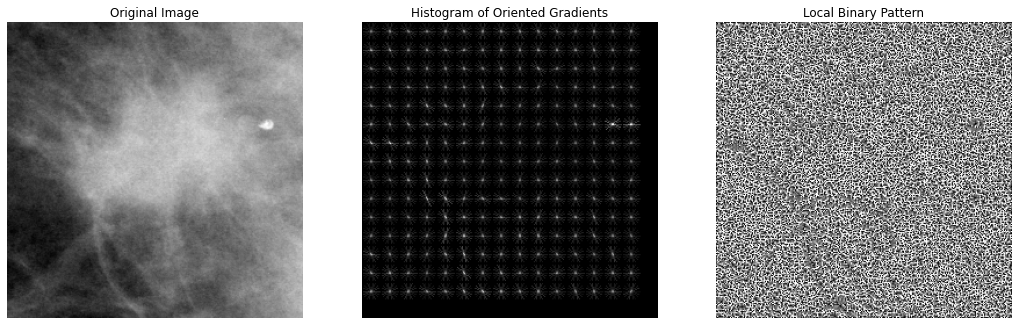

In [23]:
from skimage import io, color
from skimage.feature import hog
import matplotlib.pyplot as plt

# Load the image
image_path1 = '../../datasets/image/clean_png/Mass-Training1.png'
# image_path = 'path_to_your_image.jpg'  # Replace with the path to your image
image = io.imread(image_path1)

# Convert the image to grayscale (if it's not already)
if len(image.shape) > 2:
    image = color.rgb2gray(image)

# Resize the image to 255x255 if necessary
from skimage.transform import resize
image = resize(image, (255, 255))

# Define HOG parameters
cell_size = (16, 16)  # h x w in pixels
block_size = (1, 1)  # h x w in cells
nbins = 9  # number of orientation bins

# Compute HOG features
hog_features, hog_image = hog(image, pixels_per_cell=cell_size, cells_per_block=block_size, orientations=nbins, visualize=True, feature_vector=True)

# Define LBP parameters
radius = 1  # Radius of 3x3 window
n_points = 8 * radius  # Number of points to consider in the window

# Compute LBP features
lbp = feature.local_binary_pattern(image, n_points, radius, method="uniform")

# Display the original, HOG, and LBP images
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(hog_image, cmap=plt.cm.gray)  # Assuming hog_image from HOG code
ax[1].set_title('Histogram of Oriented Gradients')
ax[1].axis('off')

ax[2].imshow(lbp, cmap=plt.cm.gray)
ax[2].set_title('Local Binary Pattern')
ax[2].axis('off')

plt.show()